In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from __init__ import *
import numpy as np
from export.saver import read_pickle, read_pickle
from read.svg_reader import SVGReader
from helpers.helpers import filter_none
from placement2.attract import *
from visuals.plotter import plot_general
from copy import deepcopy
import networkx as nx
from itertools import pairwise, accumulate, product
from functools import reduce
from operator import add
from helpers.helpers import sort_and_group_objects
from domains.domain import Domain
from placement2.neighbors import *
from placement2.connectivity import *
from fixes.id_problems import report_problems
from new_solutions.selection import *
from helpers.layout import Layout
import plotly.io as pio
from icecream import ic


In [6]:
case  = "amber_b_f01.svg"
sv = SVGReader(case)
sv.run()
domains = sv.layout.domains
pos = create_pos(domains)


No reference for svg to meters conversion!! 


In [7]:
plot_general(sv.layout.domains)


In [8]:
ad, graphs = adjust_domains(domains)
Gx, Gy = graphs

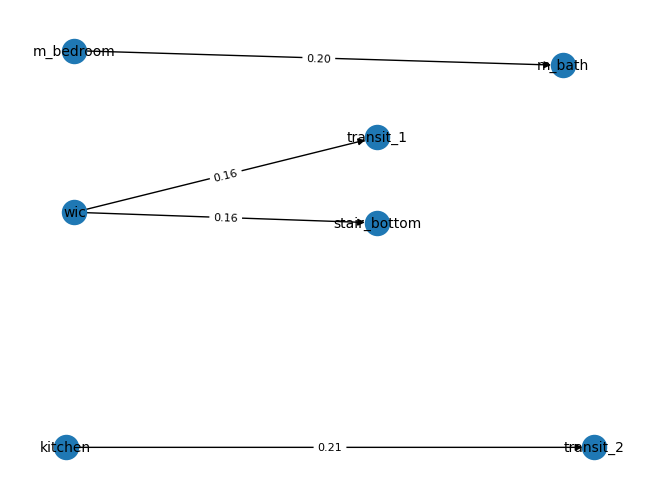

In [16]:
draw_digraph(Gx, domains )

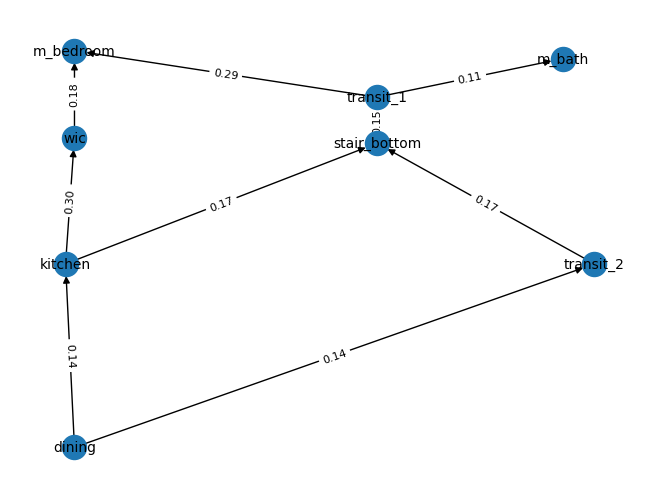

In [10]:
draw_digraph(Gy, domains )

In [11]:
plot_general(ad)

## running fixer

In [12]:
report_problems(Layout(ad, graphs))

[Problem(ix=0, HOLE, ['transit_1', 'm_bedroom'], resolved=False,  n_actions=2]

In [13]:
playout = Layout(ad, graphs)

In [14]:
re = Reporter(playout)
re.run()

In [15]:
c = Cook(re)

initializing.. 0
running again -> 1
next best layout transit_1-STRETCH-for-HOLE near ['transit_1', 'm_bedroom']1-PS:0.52-S:0.76


In [ ]:
c.results

In [115]:
c.run_again()

running again -> 2
next best layout m_bath-PUSH-for-OVERLAP near ['transit_1', 'm_bath']0-PS:0.26-S:0.13


In [116]:
c.run_again()

No more results!


In [117]:
c.run_again()

No more results!


In [118]:
c.run_again()

No more results!


In [119]:
c.run_again()

No more results!


In [120]:
c.plot_all()

n_rows 1, n_sols: 2
len sols = 2+1. Len indices = 3


In [121]:
c.bl_hist[-1]

node: m_bath, action: PUSH, summary: Counter(), # unres probs: 0

In [122]:
plot_general(c.bl_hist[-1].layout.domains)

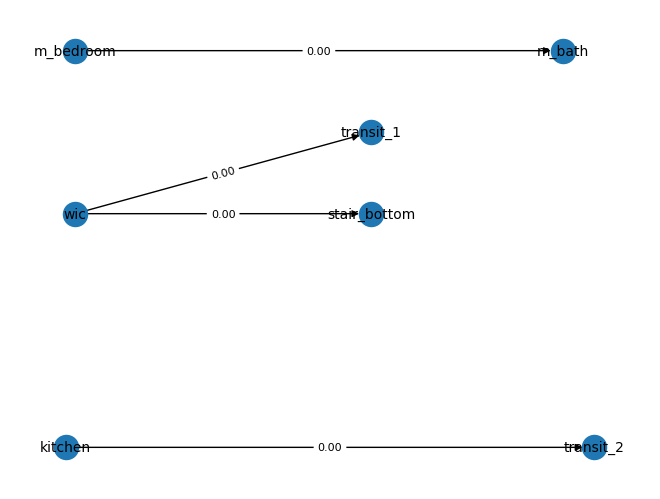

In [123]:
res_doms = c.bl_hist[-1].layout.domains
Gxr = create_graph(res_doms, "x") 
Gyr = create_graph(res_doms, "y") 
draw_digraph(Gxr, domains=res_doms)

In [124]:
set(Gxr.edges).difference(set(Gx.edges))

set()

In [125]:
set(Gyr.edges).difference(set(Gy.edges))

set()

In [128]:
save_pickle(c.bl_hist[-1].layout, "1012_good_layout")

'1012_good_layout'